**Hey Kagglers**👋👋.

Good day to all of you.🌸🌸 

Happy to present my notebook for the Kaggle Playground Series Competition - titled Regression with an Abalone Dataset. 

I have strived hard to provide you with the best content possible, keeping the notebook less wordy and more implementation friendly, as a starter for beginners and intermediate practioners. 

Please go through the notebook and play around with the code. **Upvote** if you liked the notebook - Inspires me to make more!😇😇


**Problem we are trying to solve here;**

Predict the age of abalone from physical measurements.

**Why is this a problem?**

Traditionally, the age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task. In order to reduce the manual effort, we are trying to automate the process of predicting the age by using machine learning.

**Original Source of the dataset;**

The UCI Repository : https://archive.ics.uci.edu/dataset/1/abalone


**Structure of this notebook;**

1. Basic EDA

2. Section 1; Will train different kinds of models to explore whether model complexity plays a role. We will also try stacking here with different meta learners

3. Section 2; Will conduct some feature engineering and use the original UCI dataset also for training different models and see for any improvement

**Importing the necessary libraries for the analysis;**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost
from xgboost import XGBRegressor
import lightgbm
from lightgbm import LGBMRegressor
!pip install -qq catboost
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error


## Suppress the warnings;
import warnings
warnings.filterwarnings("ignore")

## Setting the theme for plots;
sns.set_theme()
sns.set_palette(palette = "rainbow")

In [2]:
# Bonus - Helper Function to reduce memory footprint of any dataframe;
def reduce_mem_usage(df, int_cast=True, obj_to_category=True, subset=None):
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    gc.collect()
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    cols = subset if subset is not None else df.columns.tolist()
    for col in cols:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'
            if int_cast and not treat_as_int:
                treat_as_int = df[col].dtype == 'int'
            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    gc.collect()
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df


### Basic EDA:

In [3]:
## Reading the data;
data=pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')

In [4]:
data.head()

id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   Whole weight.2  Shell weight  Rings  
0          0.1465        0.2400     11  
1          0.2765        0.3200     11  
2          0.0030        0.0050      6  
3          0.2055        0.2500     10  
4          0.1600        0.1975      9

In [5]:
## dropping the id column;
data=data.drop(['id'],axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole weight    90615 non-null  float64
 5   Whole weight.1  90615 non-null  float64
 6   Whole weight.2  90615 non-null  float64
 7   Shell weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.2+ MB


In [7]:
data.describe().T

count      mean       std     min     25%     50%      75%  \
Length          90615.0  0.517098  0.118217  0.0750  0.4450  0.5450   0.6000   
Diameter        90615.0  0.401679  0.098026  0.0550  0.3450  0.4250   0.4700   
Height          90615.0  0.135464  0.038008  0.0000  0.1100  0.1400   0.1600   
Whole weight    90615.0  0.789035  0.457671  0.0020  0.4190  0.7995   1.0675   
Whole weight.1  90615.0  0.340778  0.204428  0.0010  0.1775  0.3300   0.4630   
Whole weight.2  90615.0  0.169422  0.100909  0.0005  0.0865  0.1660   0.2325   
Shell weight    90615.0  0.225898  0.130203  0.0015  0.1200  0.2250   0.3050   
Rings           90615.0  9.696794  3.176221  1.0000  8.0000  9.0000  11.0000   

                    max  
Length           0.8150  
Diameter         0.6500  
Height           1.1300  
Whole weight     2.8255  
Whole weight.1   1.4880  
Whole weight.2   0.7600  
Shell weight     1.0050  
Rings           29.0000

In [8]:
data.Sex.value_counts()

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

**Splitting the data;**

In [9]:
df, df_test=train_test_split(data, test_size=0.2)

Pre-requisites to be identified and acted upon while dealing with Regression;

1. No Multi Collinearity among independent features
2. Outlier Analysis


<Axes: xlabel='Rings', ylabel='Density'>

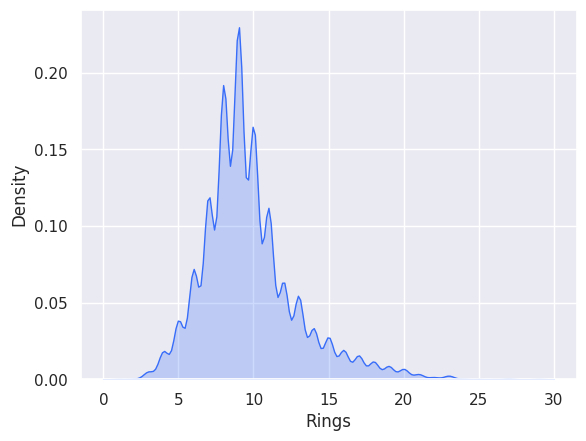

In [10]:
### Checking the distribution of the target variable;

sns.kdeplot(df.Rings,shade=True)

**Distribution is a bit right skewed.** 

We can treat this later using transformations like Power transformation, etc...

<Figure size 2000x2000 with 0 Axes>

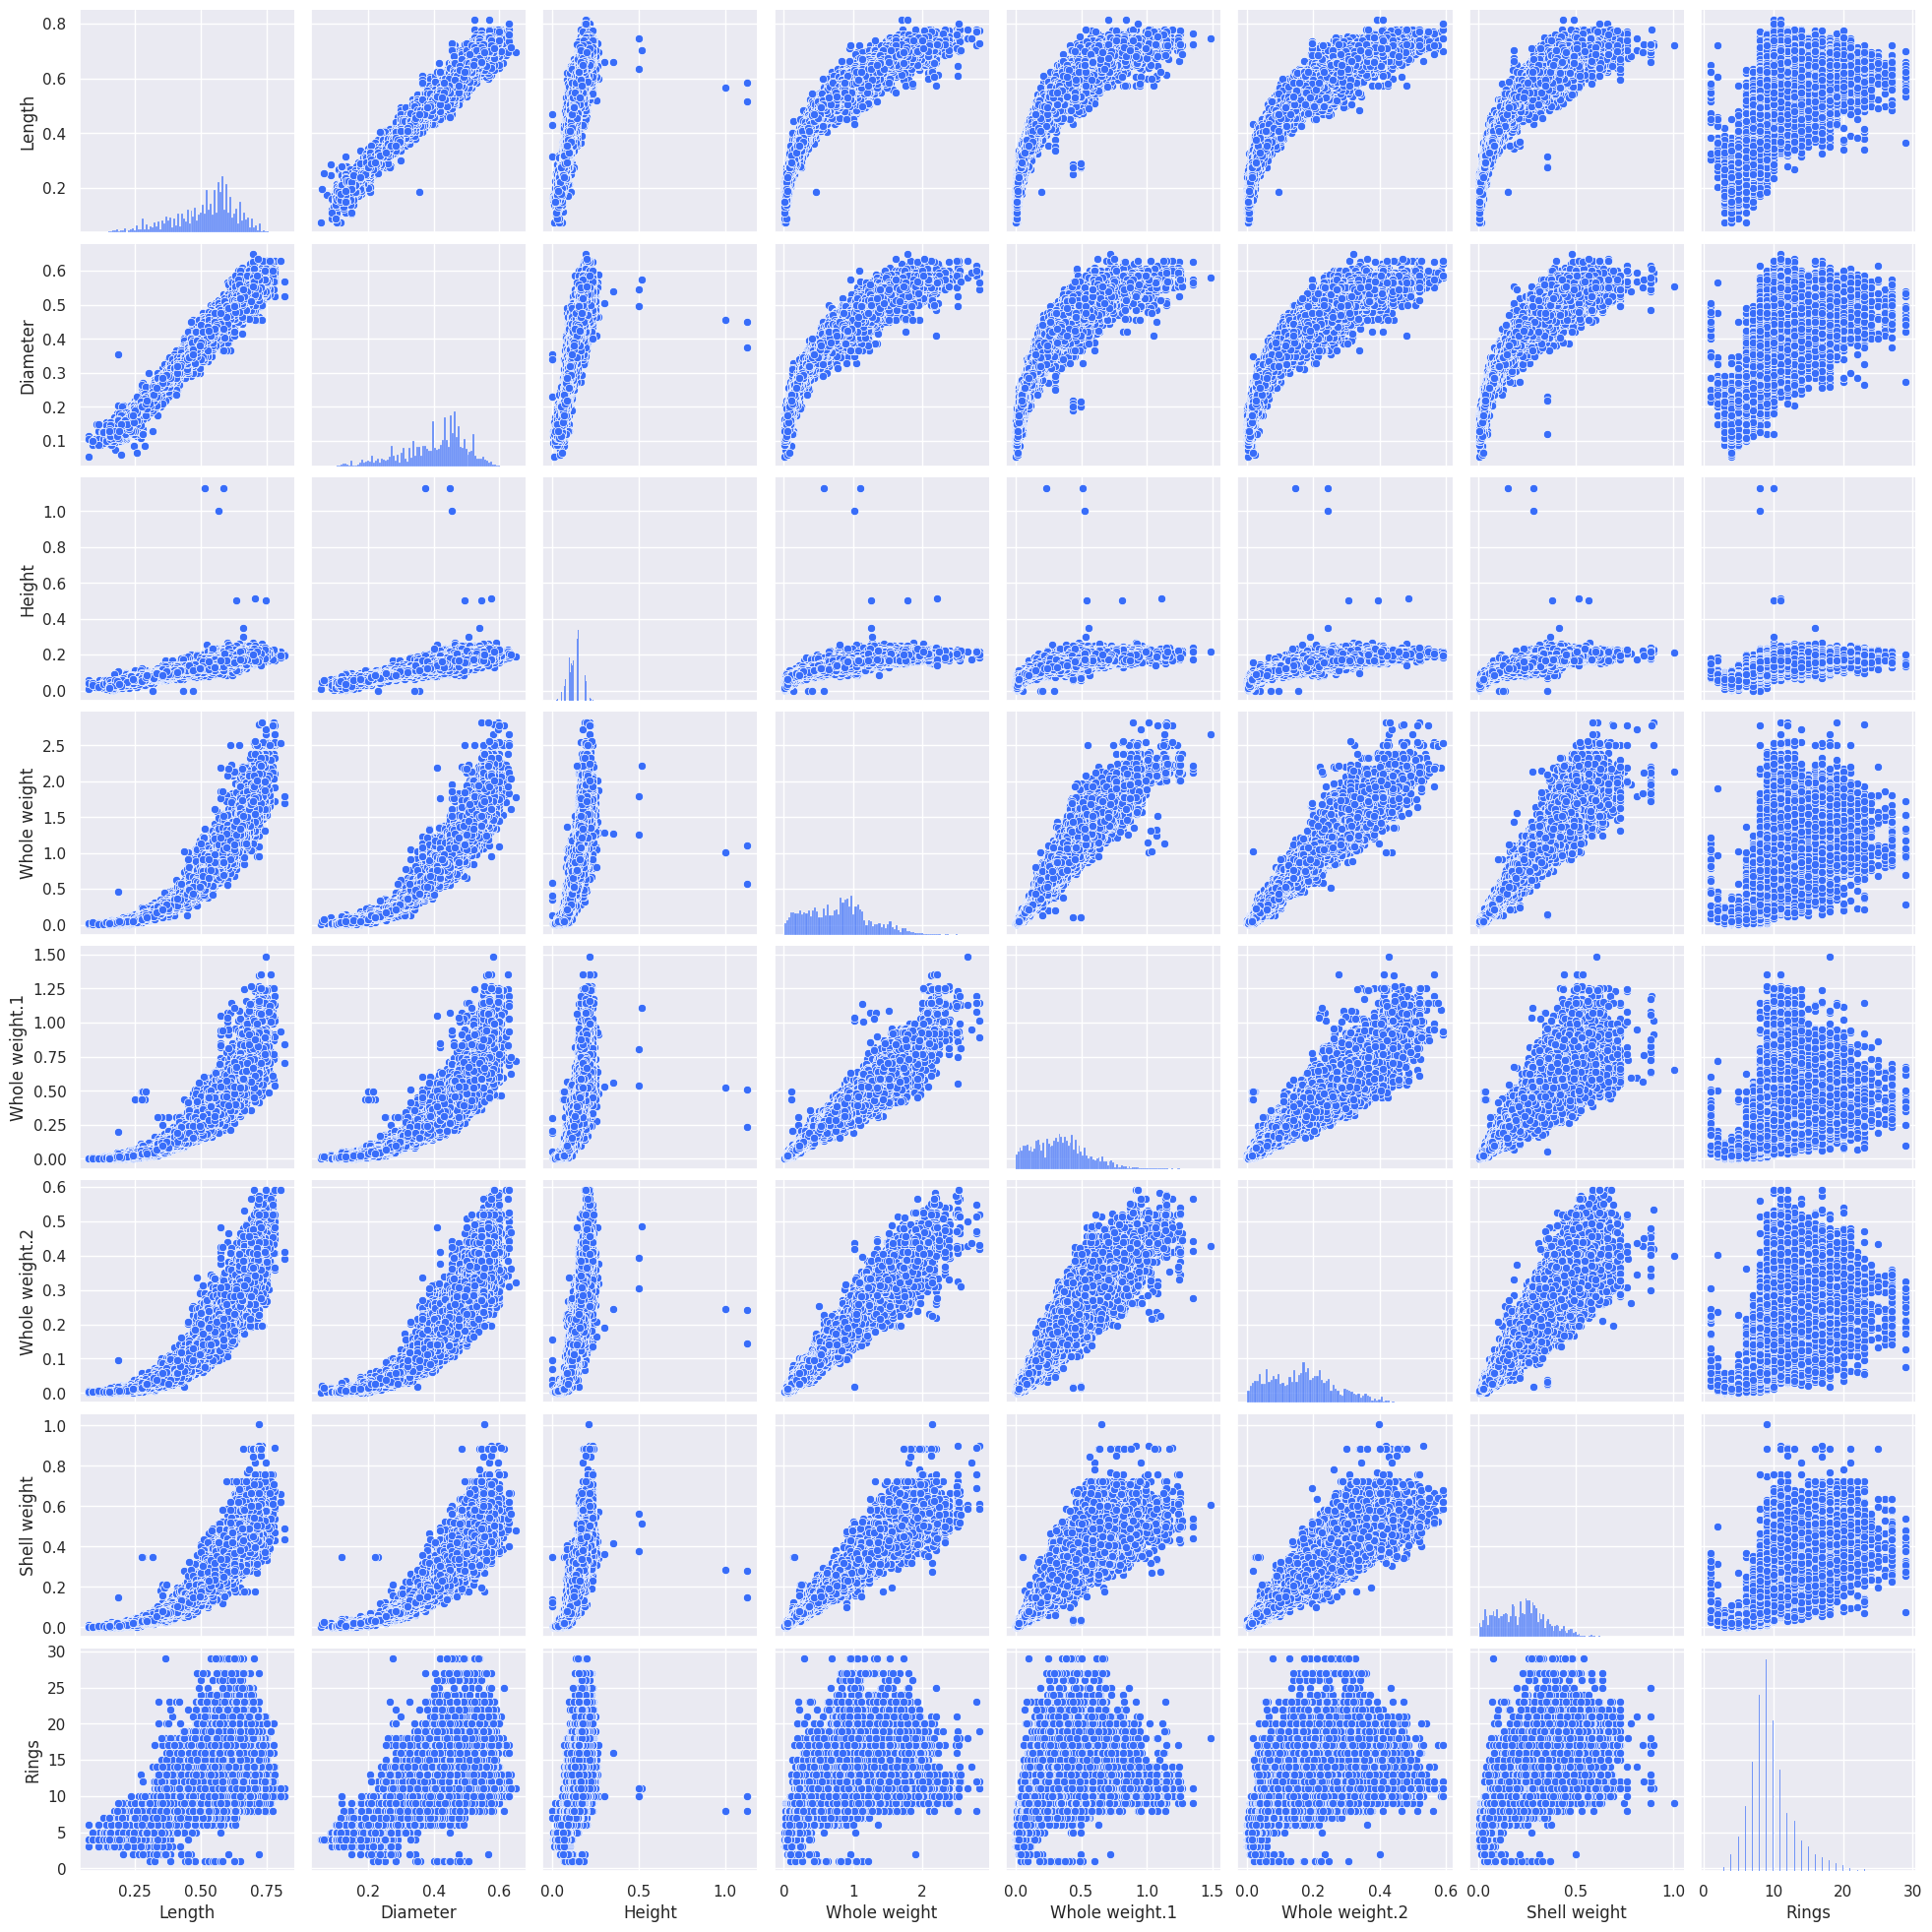

In [11]:
## Checking the relationship of each numeric variable with the Rings;

num_cols=df.select_dtypes(exclude=['object']).columns

df_num=df[num_cols]


plt.figure(figsize=(20,20))
sns.pairplot(df_num)
plt.show()

With visual inspection, we can see that some variables are **linearly** related with each other, whereas some have a **quadratic** relationship with each other also.

Also there are so many **OUTLIERS**.


0 Length
1 Diameter
2 Height
3 Whole weight
4 Whole weight.1
5 Whole weight.2
6 Shell weight
7 Rings


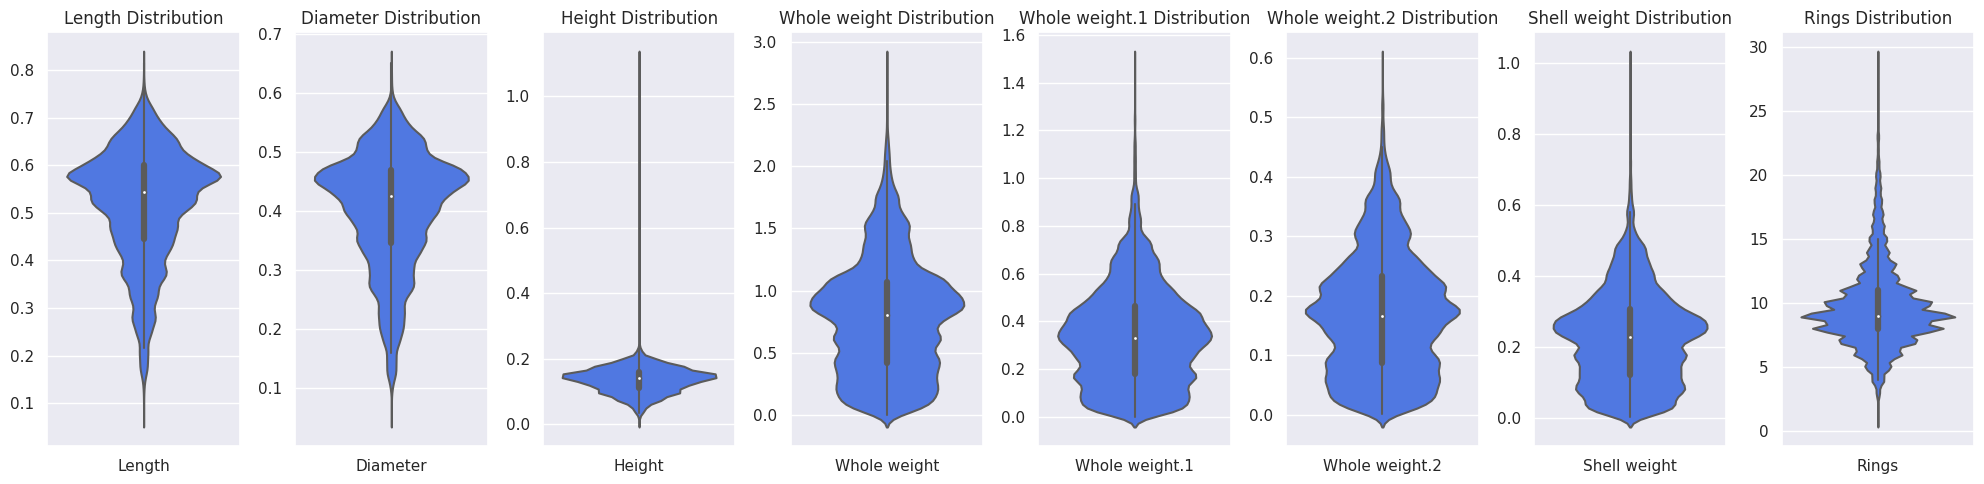

In [12]:
## Plotting the violin plots of the numerical variables;

fig,ax=plt.subplots(1,len(num_cols),figsize=(20, 5))

for plot_,col in enumerate(num_cols):
    print(plot_, col)
    sns.violinplot(df_num[[col]],ax=ax[plot_])
    ax[plot_].set_title(f'{col} Distribution')
    
# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

**The beauty of Violin Plots** are; you can observe both the presence of **Outliers** and the view the **distribution** of the dataset at the same time.

We can see here;

- Height, Whole weight, Whole weight.1, Whole weight.2, Shell weight are **Right Skewed**.

- Length and Diameter are **Left Skewed**.


We need to treat the different types of skewness with different **transformation** technique.

**Outlier Treatment:**

- For handling **Right** skewed data, we could use **Log** Transform, **Square Root** Transformation

- For handling **Left** skewed data, we could use **Square** Transform, **Cube** Transformation

Apart from the above said methods, we can use methods like **Box-Cox** Transformation, but it will work only if our data points is **strictly positive**.

A more robust technique, is called the **Yeo-Johnson** Transformation, that can handle any distribution.

If you want to read more about Outlier Handling, please read here; https://www.kaggle.com/code/aimack/how-to-handle-skewed-distribution



In [13]:
# Viewing the skewness before transforming;
old_skew = df_num.skew().sort_values(ascending=False)
old_skew

Rings             1.201987
Whole weight.1    0.584766
Shell weight      0.473741
Whole weight.2    0.467779
Height            0.425056
Whole weight      0.422229
Diameter         -0.696992
Length           -0.732730
dtype: float64

In [14]:
from sklearn.preprocessing import PowerTransformer

In [15]:
def yeojohntrans_impact(feature):   # function to apply transformer and check the distribution with histogram and kdeplot
    
    yeojohnTr = PowerTransformer(standardize=True)   # not using method attribute as yeo-johnson is the default

    plt.figure(figsize=(15,3))
    plt.subplot(1,2,1)
    plt.title("Distribution before Transformation", fontsize=15)
    sns.histplot(df[feature], kde=True, color="red")
    plt.subplot(1,2,2)
    
    df_yeojohn = pd.DataFrame(yeojohnTr.fit_transform(df[feature].values.reshape(-1,1)))
    plt.title("Distribution after Transformation", fontsize=15)
    sns.histplot(df_yeojohn,bins=20, kde=True , legend=False)
    plt.xlabel(feature)
    plt.show()
    
    print(f"Skewness was {round(old_skew[feature],2)} before & is {round(df_yeojohn.skew()[0],2)} after Yeo-johnson transformation.")
    

Height


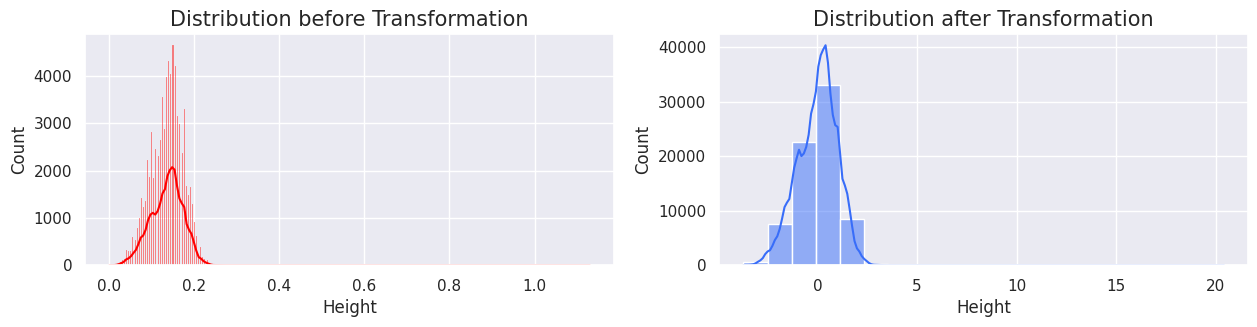

Skewness was 0.43 before & is 0.02 after Yeo-johnson transformation.
----------------------------------------------------------------------------------------------------------------------------------------
Whole weight


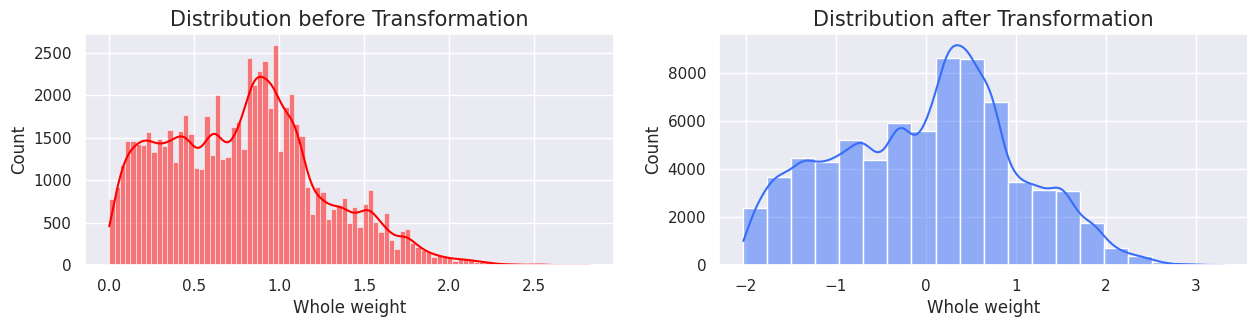

Skewness was 0.42 before & is -0.01 after Yeo-johnson transformation.
----------------------------------------------------------------------------------------------------------------------------------------
Whole weight.1


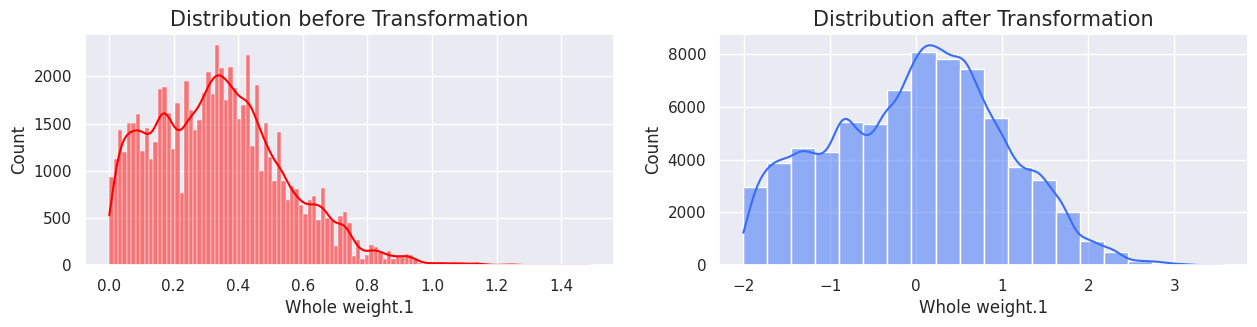

Skewness was 0.58 before & is 0.02 after Yeo-johnson transformation.
----------------------------------------------------------------------------------------------------------------------------------------
Whole weight.2


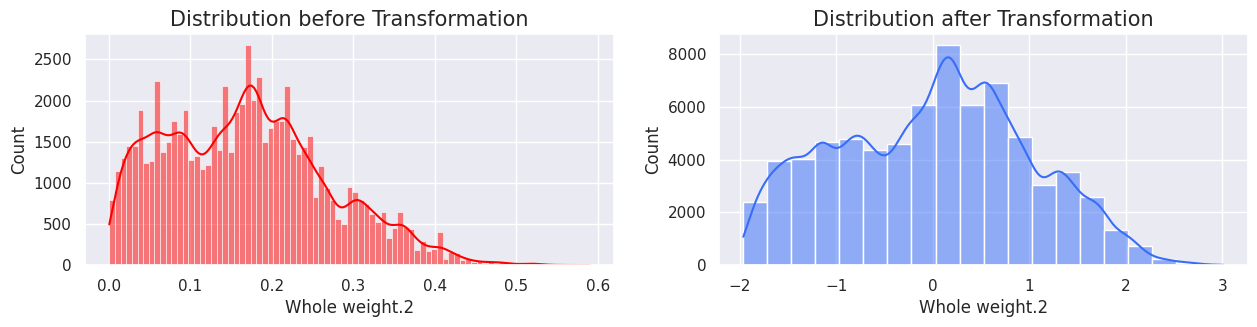

Skewness was 0.47 before & is 0.03 after Yeo-johnson transformation.
----------------------------------------------------------------------------------------------------------------------------------------
Shell weight


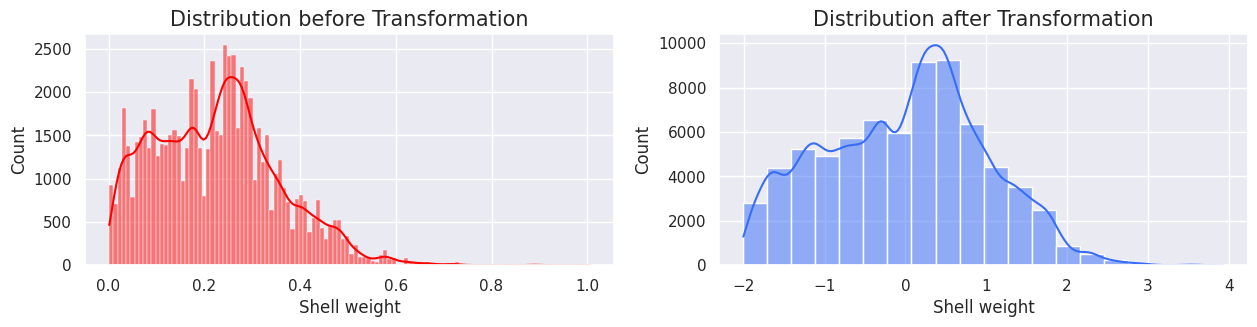

Skewness was 0.47 before & is 0.02 after Yeo-johnson transformation.
----------------------------------------------------------------------------------------------------------------------------------------


In [16]:
## Treating the left skewed variables with power transformation

## We will use the Box-Cox Transformation;
left_skew_col=['Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']

for i in left_skew_col:
    print(i)
    yeojohntrans_impact(feature=i)
    print('----------------------------------------------------------------------------------------------------------------------------------------')

As you can visually see, skewness of the variables are reduced to certain extent and tends towards zero - indicating perfect normality.

Height


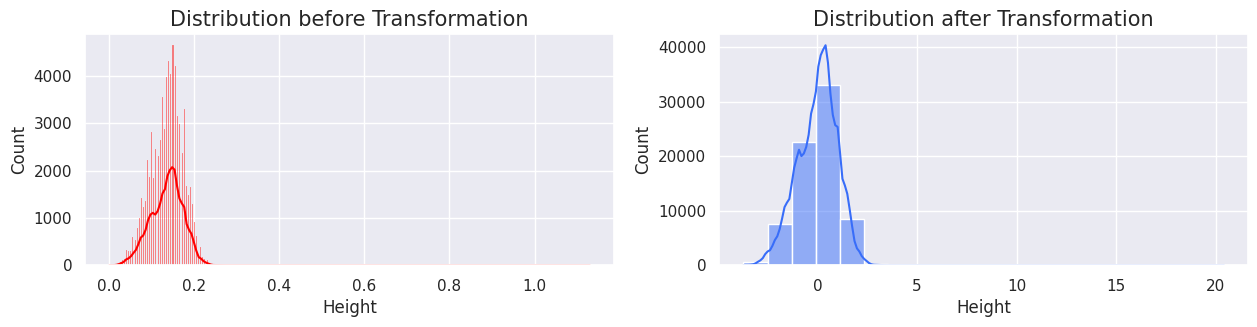

Skewness was 0.43 before & is 0.02 after Yeo-johnson transformation.
----------------------------------------------------------------------------------------------------------------------------------------
Diameter


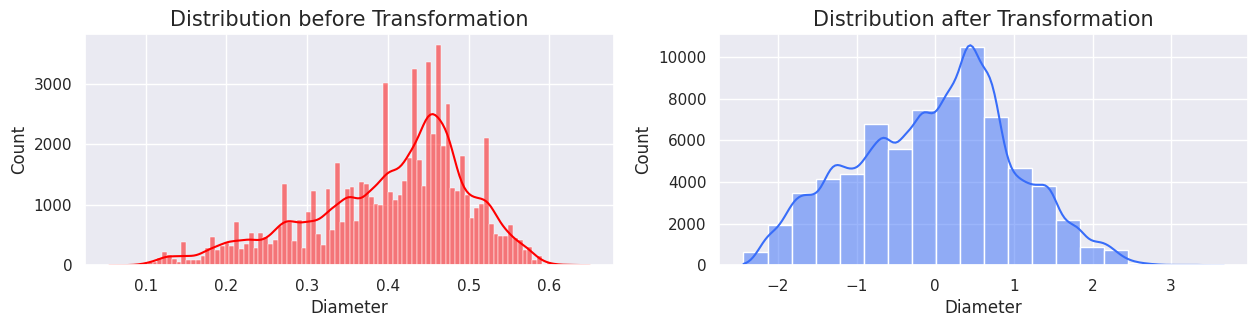

Skewness was -0.7 before & is -0.08 after Yeo-johnson transformation.
----------------------------------------------------------------------------------------------------------------------------------------


In [17]:
## Treating the right skewed variables with log transformation

## We will use log transformation;

right_skew_col=['Height','Diameter']

for i in right_skew_col:
    print(i)
    yeojohntrans_impact(feature=i)
    print('----------------------------------------------------------------------------------------------------------------------------------------')

In [18]:
## Defining the helper function to transform the dataset;

def yeojohntrans_transform(feature):
    
    yeojohnTr = PowerTransformer(standardize=True)
    df_yeojohn = pd.DataFrame(yeojohnTr.fit_transform(df[feature].values.reshape(-1,1)))
    
    return df_yeojohn

In [19]:
df_num_transformed=df_num.copy()

for i in num_cols:
    print(i)
    df_num_transformed[i]=yeojohntrans_transform(i)

Length
Diameter
Height
Whole weight
Whole weight.1
Whole weight.2
Shell weight
Rings


In [20]:
# Viewing the skewness before transforming;
old_skew = df_num.skew().sort_index()
old_skew

Diameter         -0.696992
Height            0.425056
Length           -0.732730
Rings             1.201987
Shell weight      0.473741
Whole weight      0.422229
Whole weight.1    0.584766
Whole weight.2    0.467779
dtype: float64

In [21]:
# Viewing the skewness after transforming;
old_skew = df_num_transformed.skew().sort_index()
old_skew

Diameter         -0.081058
Height           -0.043405
Length           -0.081851
Rings             0.002836
Shell weight      0.015872
Whole weight     -0.015650
Whole weight.1    0.016307
Whole weight.2    0.028961
dtype: float64

- As you can see in the above comparison, the transformations have reduced the skewness.

Checking the impact of the categorical variable on the target;

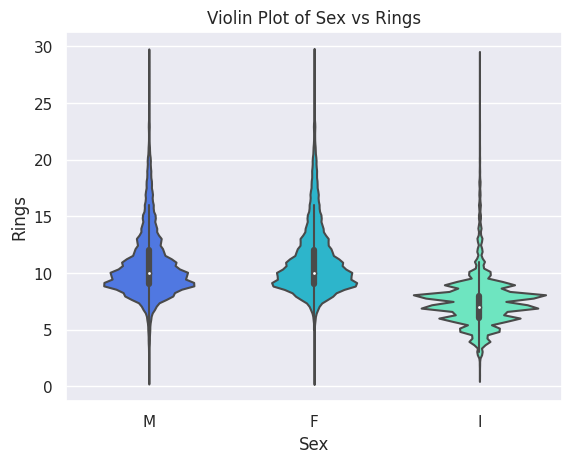

In [22]:
sns.violinplot(x=df.Sex, y=df.Rings)
plt.xlabel('Sex')
plt.ylabel('Rings')
plt.title('Violin Plot of Sex vs Rings')
plt.show()

- As seen above, **Sex = 'I'** has some visible impact on the Age of the Abalone, as majority of the Abalone which belong to Sex 'I' have an age bracket of **[5,10]**. 

- Whereas for the other sex (**Sex = 'M'/'F'**), we see that majority of the age lies in the bracket of **[8,13]** and is skewed towards the right.

**Checking for Multi-Collinearity;**

Here, we plot the correlation matrix.

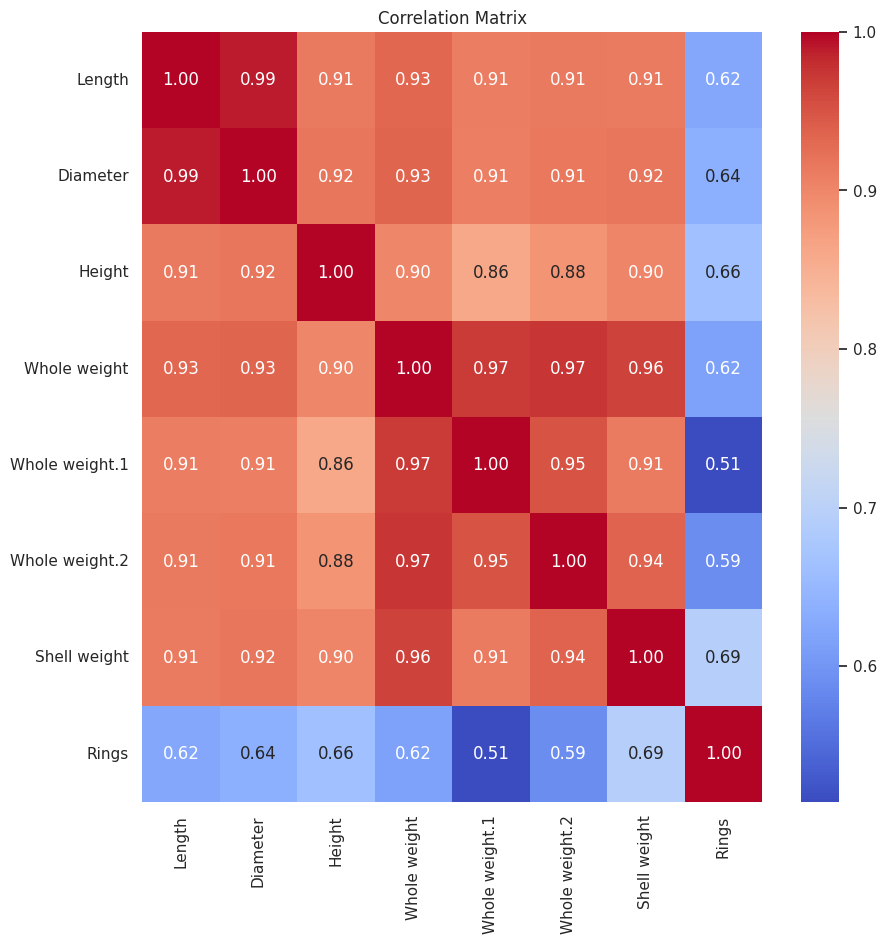

In [23]:
# Calculate the correlation matrix
correlation_matrix = df_num.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

We see from the above plot that all the features are correlated among each other. Since, we have limited features, I am not removing them.

Hence, let me try out parametric models like Ridge and Lasso Regression that zeroes out coefficients based on the impact of the features on the dependent variable.

### Section 1:

**Modelling Part**:

In [24]:
## Storing the list of categorical and numerical columns;
num_cols=list(df.select_dtypes('float64').columns)
cat_cols=list(df.select_dtypes('object').columns)

num_cols,cat_cols

(['Length',
  'Diameter',
  'Height',
  'Whole weight',
  'Whole weight.1',
  'Whole weight.2',
  'Shell weight'],
 ['Sex'])

The **Data pipeline** consists of the following preprocessing steps;

1. Transformation of the numeric variables using Power Transformation
2. Scaling the numeric variables
3. One Hot encode the categorical variables
3. Model


In [25]:
def pipeline_flow(model):

    # Define the preprocessing steps for numerical variables
    numerical_transformer = Pipeline(steps=[
        ('power_transformer', PowerTransformer(standardize=True)),  # Step 1: Transform numerical variables
        ('standard_scaler', StandardScaler())                       # Step 2: Scale the features
    ])

    # Define the preprocessing steps for categorical variables
    categorical_transformer = Pipeline(steps=[
        ('onehot_encoder', OneHotEncoder())  # Step 3: One-hot encode the categorical variables
    ])

    # Create a ColumnTransformer to apply the preprocessing steps to numerical and categorical variables
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

    # Define the steps in the pipeline
    steps = [
        ('preprocessor', preprocessor),        # Preprocessing steps
        ('model', model)    # Step 4: Model
    ]

    # Create the pipeline
    pipeline = Pipeline(steps)
    
    return pipeline

In [26]:
## Preparing the data for model training;

## Defining the X and y;
X=df.drop(['Rings'],axis=1)
y=df['Rings']

X.shape,y.shape

((72492, 8), (72492,))

In [27]:
## Defining a helper function for easy representation;

def append_to_dataframe(df, model_name, cv_scores, metric):
    """
    Appends a new row to an existing DataFrame with model name, cross-validation scores,
    and a metric.
    """
    # Create a dictionary for the new row
    new_row = {
        'model_name': model_name,
        'cv1': cv_scores[0],
        'cv2': cv_scores[1],
        'cv3': cv_scores[2],
        'cv4': cv_scores[3],
        'cv5': cv_scores[4],
        'metric': metric
    }
    
    # Append the new row to the DataFrame
    df = pd.concat([df,pd.DataFrame(new_row,index=[0])],axis=0).reset_index(drop=True)
    
    return df

## Defining the dataframe to store the results for later analysis.
master = pd.DataFrame()

# # Example usage of the function
# model_name = 'Model C'
# cv_scores = [0.79, 0.75, 0.77, 0.81, 0.78]
# metric = 'f1_score'

# df = append_to_dataframe(df, model_name, cv_scores, metric)

In [28]:
## Taking the Lasso Model;
model=Lasso()
pipeline=pipeline_flow(model)

In [29]:
## Viewing the pipeline to view the steps being followed;

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('model', Lasso())])

In [30]:
# Perform cross-validation with the 'neg_mean_squared_error' scoring
cv_scores_mse = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold cross-validation
cv_scores_mse

array([-6.12733681, -6.01382721, -6.15692922, -6.03495681, -6.23567807])

In [31]:
# Perform cross-validation with the 'r2' scoring
cv_scores_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')  # 5-fold cross-validation
cv_scores_r2

array([0.3948909 , 0.39711675, 0.3993494 , 0.39595446, 0.39227777])

In [32]:
## Storing the results in a dataframe with the help of the helper function;

master=append_to_dataframe(master,'Lasso',cv_scores_mse,'neg_mean_squared_error')
master=append_to_dataframe(master,'Lasso',cv_scores_r2,'r2')

In [33]:
## To get a list of names of the diffent scoring parameters available;

# import sklearn
# sklearn.metrics.get_scorer_names()

In [34]:
## Taking the Ridge Model;
model=Ridge()
pipeline=pipeline_flow(model)

# Perform cross-validation
cv_scores_mse = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold cross-validation
cv_scores_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')  # 5-fold cross-validation

master=append_to_dataframe(master,'Ridge',cv_scores_mse,'neg_mean_squared_error')
master=append_to_dataframe(master,'Ridge',cv_scores_r2,'r2')

In [35]:
cv_scores_mse

array([-3.94234141, -3.91740974, -3.9228036 , -3.82129913, -3.94769026])

In [36]:
cv_scores_r2

array([0.61067153, 0.60728158, 0.61730365, 0.61752192, 0.61526251])

**Ridge Performs better than Lasso**, probably because of the fact that Lasso might be making some of the coefficient of the final regression line to be zero, thus eliminating some variables in the process, whereas Ridge is not exactly zeroing out the coeffients, rather reducing the weight of those coefficients.

In [37]:
## Helper function to return the cv scores;
def model_evaluation(pipeline,X,y):

    cv_scores_mse = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')  # 5-fold cross-validation
    
    cv_scores_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2')  # 5-fold cross-validation

    return cv_scores_mse,cv_scores_r2

In [38]:
## Taking the Light GBM Model;
model=LGBMRegressor()
pipeline=pipeline_flow(model)

cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
master=append_to_dataframe(master,'Light GBM',cv_scores_mse,'neg_mean_squared_error')
master=append_to_dataframe(master,'Light GBM',cv_scores_r2,'r2')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 57993, number of used features: 10
[LightGBM] [Info] Start training from score 9.702550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set: 57993, number of used features: 10
[LightGBM] [Info] Start training from score 9.702481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1330
[LightGBM] [Info] Number of data points in the train set

Notice that the **training time of Random Forest is longer** than the other models. This is because Decision Trees and Random Forest takes up lots of computational time in deciding which features are to be used at what level of the individual tree(s) to yield the **most minimized variance** (impurity) at each node.

In [39]:
## Taking the XGBoost Model;
model=XGBRegressor()
pipeline=pipeline_flow(model)

cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
master=append_to_dataframe(master,'XGBoost',cv_scores_mse,'neg_mean_squared_error')
master=append_to_dataframe(master,'XGBoost',cv_scores_r2,'r2')

Visualising the results obtained so far;

In [40]:
## Viewing the results table;

master.head()

model_name       cv1       cv2       cv3       cv4       cv5  \
0      Lasso -6.127337 -6.013827 -6.156929 -6.034957 -6.235678   
1      Lasso  0.394891  0.397117  0.399349  0.395954  0.392278   
2      Ridge -3.942341 -3.917410 -3.922804 -3.821299 -3.947690   
3      Ridge  0.610672  0.607282  0.617304  0.617522  0.615263   
4  Light GBM -3.488929 -3.447945 -3.437919 -3.420295 -3.463610   

                   metric  
0  neg_mean_squared_error  
1                      r2  
2  neg_mean_squared_error  
3                      r2  
4  neg_mean_squared_error

In [41]:
## Helper function to plot the results;

def plot_cv_scores(df, metric):
    """
    Plots line plots for cross-validation scores of each model.

    Parameters:
    - df: DataFrame containing model names, cross-validation scores, and metric.
    - metric: The metric to be plotted (e.g., 'accuracy', 'precision', 'f1_score', etc.).
    """
    # Filter dataframe for the specified metric
    df_metric = df[df['metric'] == metric]

    # Get unique model names
    models = df_metric['model_name'].unique()

    # Plot each model's CV scores
    plt.figure(figsize=(10, 6))
    for model in models:
        model_data = df_metric[df_metric['model_name'] == model]
        plt.plot(range(1, 6), model_data.iloc[:, 1:6].values.flatten(), marker='o', label=model)

    # Add labels and legend
    plt.title(f'Cross-validation Scores ({metric})')
    plt.xlabel('Cross-validation')
    plt.ylabel('Score')
    plt.xticks(range(1, 6), ['cv1', 'cv2', 'cv3', 'cv4', 'cv5'])
    plt.legend()

    # Show plot
    plt.grid(True)
    plt.show()

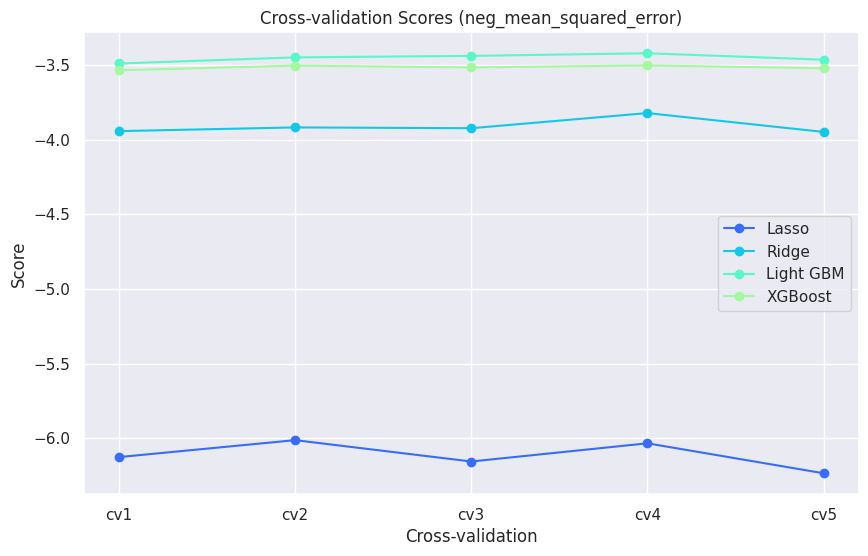

In [42]:
plot_cv_scores(master, 'neg_mean_squared_error')

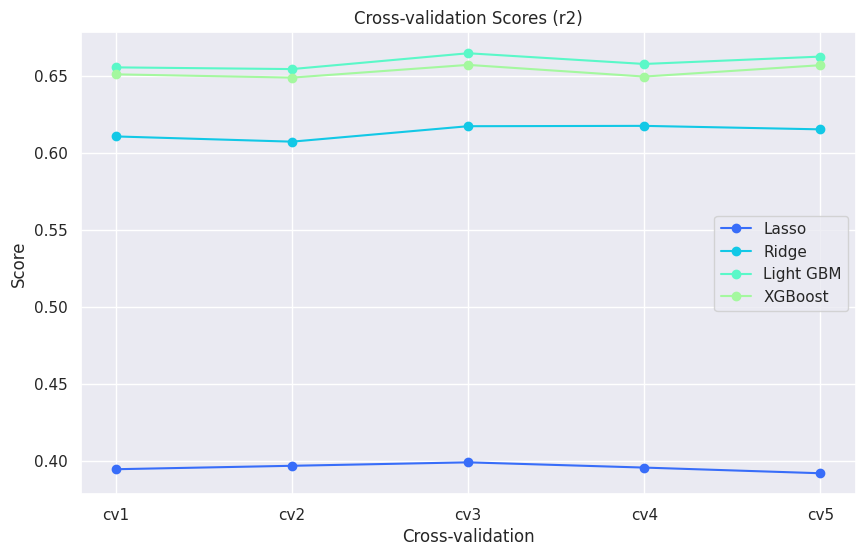

In [43]:
plot_cv_scores(master, 'r2')

**As seen above, the baseline LGBM model slightly outperforms all the other models.**

**Training the Baseline LGBM model**:

In [44]:
final_model=LGBMRegressor()
final_pipeline=pipeline_flow(final_model)

final_pipeline.fit(X,y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1336
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 10
[LightGBM] [Info] Start training from score 9.706850


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('model', LGBMRegressor())])

In [45]:
## Viewing the steps followed;
final_pipeline.named_steps

{'preprocessor': ColumnTransformer(transformers=[('num',
                                  Pipeline(steps=[('power_transformer',
                                                   PowerTransformer()),
                                                  ('standard_scaler',
                                                   StandardScaler())]),
                                  ['Length', 'Diameter', 'Height',
                                   'Whole weight', 'Whole weight.1',
                                   'Whole weight.2', 'Shell weight']),
                                 ('cat',
                                  Pipeline(steps=[('onehot_encoder',
                                                   OneHotEncoder())]),
                                  ['Sex'])]),
 'model': LGBMRegressor()}

To **map** the individual feature to their original features, I took reference from these articles;

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/extracting-feature-importances-from-scikit-learn-pipelines-18c79b4ae09a&strip=0&vwsrc=1&referer=medium-parser

https://stackoverflow.com/questions/51905524/plot-feature-importance-with-xgboost


In [46]:
# onehot_columns = list(final_pipeline.named_steps['preprocessor']\
#                       .named_transformers_['cat']\
#                       .named_steps['onehot_encoder']\
#                       .get_feature_names_out(input_features=cat_cols))

# all_features = list(num_cols)
# all_features.extend(onehot_columns)

In [47]:
## Alternate way to get all the feature names, including the one-hot encoded features;
all_features=list(final_pipeline[0].get_feature_names_out())

In [48]:
## Prints the One Hot Encoded features also;
all_features

['num__Length',
 'num__Diameter',
 'num__Height',
 'num__Whole weight',
 'num__Whole weight.1',
 'num__Whole weight.2',
 'num__Shell weight',
 'cat__Sex_F',
 'cat__Sex_I',
 'cat__Sex_M']

Time to find out what were the important features considered by the model;

**For XGBoost;**

**The available feature importance types in XGBoost are : [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]**

**Plotting the feature importance in terms of GAIN and WEIGHT**;

In [49]:
# # Extract XGBoost model from pipeline
# xgb_model = final_pipeline.named_steps['model']

# # Plot feature importances
# xgb_model.get_booster().feature_names = all_features

# f = 'gain'   ### Choosing the metric
# xgboost.plot_importance(xgb_model.get_booster().get_score(importance_type= f))


In [50]:
# # Extract XGBoost model from pipeline
# xgb_model = final_pipeline.named_steps['model']

# # Plot feature importances
# ## 'weight'
# xgb_model.get_booster().feature_names = all_features

# f = 'weight'
# xgboost.plot_importance(xgb_model.get_booster().get_score(importance_type= f))


You can either use the inbuilt feature importance method in the model or alternatively use the **eli5** (Explain Like I am 5) package for feature importance;

In [51]:
!pip install -qq eli5
import eli5

2024-04-27 09:01:31.312937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 09:01:31.313077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 09:01:31.476306: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [52]:
## The weights add up to one;
eli5.explain_weights(final_pipeline.named_steps['model'], feature_names=all_features)

Explanation(estimator='LGBMRegressor()', description='\nLightGBM feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=True, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='num__Shell weight', weight=0.76179006265203, std=None, value=None), FeatureWeight(feature='num__Whole weight.1', weight=0.1274988086893233, std=None, value=None), FeatureWeight(feature='num__Height', weight=0.037490658144495086, std=None, value=None), FeatureWeight(feature='num__Whole weight', weight=0.028246537037552408, std=None, value=None), FeatureWeight(feature='num__Length', weight=0.01411660835391093, std=None, value=None), FeatureWeight(feature='num__Whole weight.2', weight=0.012595109354649104, std=None, value=None), FeatureWeight(feature='cat__Sex_I', weight=0.010282259841215217, std=None, value=None), FeatureWeight(feature='num__Diameter', weight=0.007022529491943183, std=None, value=None), FeatureWeight(feature='cat__Sex_F', weight=0.0006869366146118396, std=None, value=None), FeatureWeight(feature='cat__Sex_M', weight=0.00027048982026889903, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

So as we had predicted during the EDA, the model has learnt that **Sex = 'I'** explains the target variable well.

In [53]:
## Checking the validation score;

X_val=df_test.drop(['Rings'],axis=1)
y_val=df_test['Rings']

## Getting predictions from the baseline pipeline;

preds = final_pipeline.predict(X_val)

In [54]:
## calculating the MSE;

mean_squared_error(y_val,preds)**0.5

1.8192161536530735

In [55]:
### Comparing with XGB's performance for validation; 
final_model_2=XGBRegressor()
final_pipeline_2=pipeline_flow(final_model_2)

final_pipeline_2.fit(X,y)

## Getting predictions from the baseline pipeline;

preds_2 = final_pipeline_2.predict(X_val)

mean_squared_error(y_val,preds_2)**0.5

1.8285617810742647

As we can see, error is slightly less in the case of Light GBM model. We shall submit an initial prediction as a start.

Combining the validation model to train the final baseline model;

In [56]:
entire_dataset=pd.concat([df,df_test],axis=0).reset_index(drop=True)
X=entire_dataset.drop(['Rings'],axis=1)
y=entire_dataset['Rings']

In [57]:
final_model=LGBMRegressor()
final_pipeline=pipeline_flow(final_model)

final_pipeline.fit(X,y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 10
[LightGBM] [Info] Start training from score 9.696794


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Whole weight.1',
                                                   'Whole weight.2',
                                                   'Shell weight']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('model', LGBMRegressor())])

In [58]:
## Reading the test dataset;

test = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')
test.head()

id Sex  Length  Diameter  Height  Whole weight  Whole weight.1  \
0  90615   M   0.645     0.475   0.155        1.2380          0.6185   
1  90616   M   0.580     0.460   0.160        0.9830          0.4785   
2  90617   M   0.560     0.420   0.140        0.8395          0.3525   
3  90618   M   0.570     0.490   0.145        0.8740          0.3525   
4  90619   I   0.415     0.325   0.110        0.3580          0.1575   

   Whole weight.2  Shell weight  
0          0.3125        0.3005  
1          0.2195        0.2750  
2          0.1845        0.2405  
3          0.1865        0.2350  
4          0.0670        0.1050

In [59]:
final_prediction = final_pipeline.predict(test.drop(['id'],axis=1))
final_submission=test[['id']]
final_submission['Rings'] = final_prediction

In [60]:
final_submission.head()

id      Rings
0  90615   9.766868
1  90616   9.687485
2  90617  10.311527
3  90618  10.315426
4  90619   7.523165

In [61]:
final_submission.to_csv('submission_lgb.csv',index=False)

**Trying the Stacking Ensemble Approach;**

In stacking, an algorithm takes the outputs of various sub-models or base learners as input and attempts to learn how to best combine the input predictions to make a better output prediction.

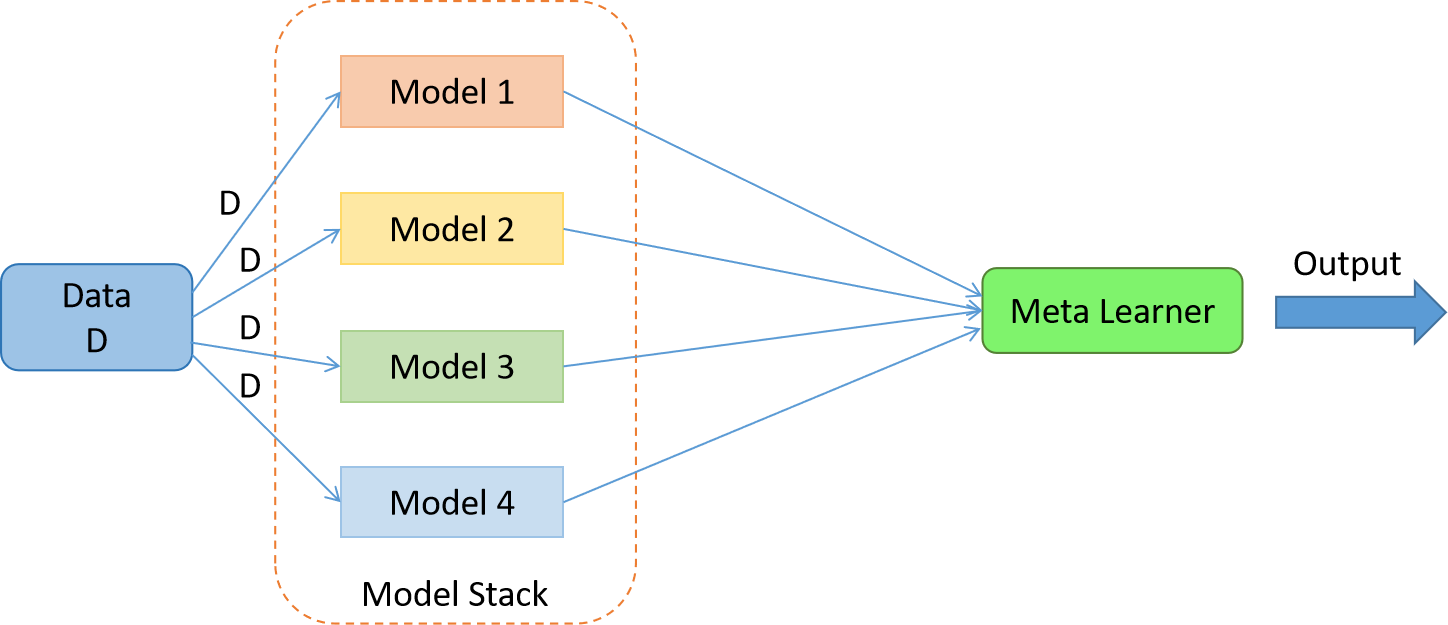

In [62]:
## Creating a master table to store the metrics of the individual base learners;

stacking_results=pd.DataFrame()

In [63]:
## Defining 4 arbitrary baseline models;

model1 =  DecisionTreeRegressor()
model2 =  KNeighborsRegressor()
## model3 = SVR()   from sklearn.svm import SVR
model3 = XGBRegressor()
model4 = LGBMRegressor()


## Creating into a list of (name, estimator object) pairs
clf = [('dtr',model1),('knn',model3),('xgb',model4),('lgm',model4),] #list of (str, estimator)

In [64]:
%%time
def base_accuracy(model_name,model,stacking_results):
    pipeline=pipeline_flow(model)
    cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
    stacking_results=append_to_dataframe(stacking_results,model_name,cv_scores_mse,'neg_mean_squared_error')
    stacking_results=append_to_dataframe(stacking_results,model_name,cv_scores_r2,'r2')   
    
    return stacking_results

## Iterating through every base model and getting their base loss;
for model_name,model in clf:
    print(model_name)
    stacking_results = base_accuracy(model_name, model, stacking_results)


dtr
knn
xgb
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 10
[LightGBM] [Info] Start training from score 9.688407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 10
[LightGBM] [Info] Start training from score 9.691331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 10
[LightGBM] [Inf

In [65]:
%%time
### Let us consider the XGB to be the meta-learner and check its performance;
meta_model_1 = XGBRegressor()

stack_model = StackingRegressor( estimators = clf,final_estimator = meta_model)

pipeline=pipeline_flow(stack_model)

cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
stacking_results=append_to_dataframe(stacking_results,'stacked_ensemble_xgb',cv_scores_mse,'neg_mean_squared_error')
stacking_results=append_to_dataframe(stacking_results,'stacked_ensemble_xgb',cv_scores_r2,'r2') 


NameError: name 'meta_model' is not defined

In [66]:
%%time
### Let us consider the Light GBM to be the meta-learner and check its performance;
meta_model_2 = LGBMRegressor()

stack_model = StackingRegressor( estimators = clf,final_estimator = meta_model)

pipeline=pipeline_flow(stack_model)

cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
stacking_results=append_to_dataframe(stacking_results,'stacked_ensemble_lgb',cv_scores_mse,'neg_mean_squared_error')
stacking_results=append_to_dataframe(stacking_results,'stacked_ensemble_lgb',cv_scores_r2,'r2') 


NameError: name 'meta_model' is not defined

Time to compare our results;

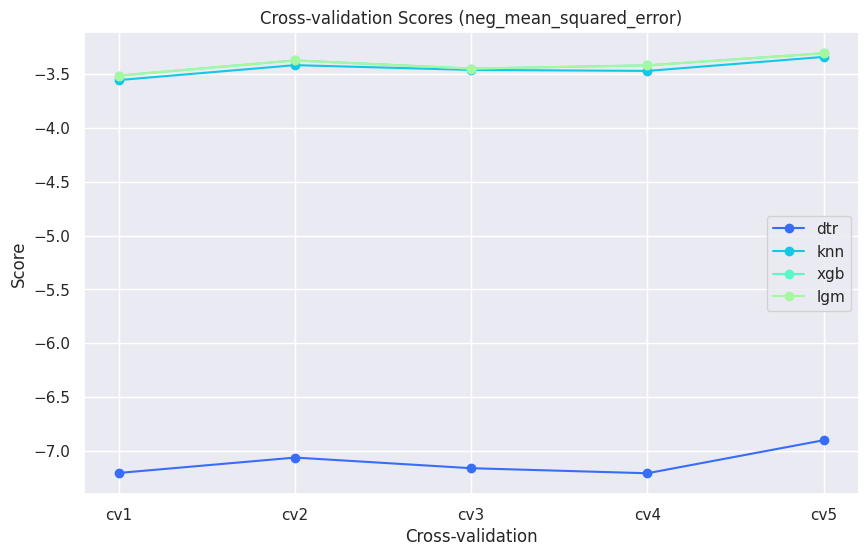

In [67]:
plot_cv_scores(stacking_results, 'neg_mean_squared_error')

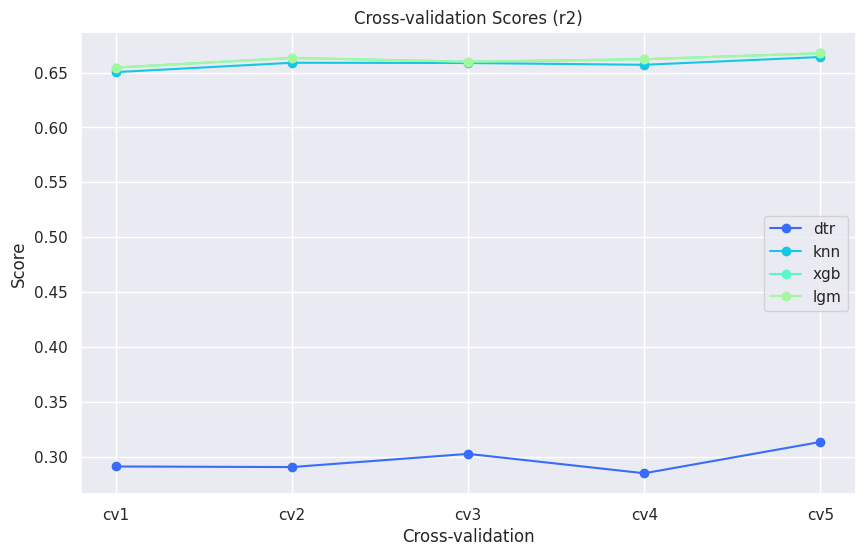

In [68]:
plot_cv_scores(stacking_results, 'r2')

In [69]:
stacking_results

model_name       cv1       cv2       cv3       cv4       cv5  \
0        dtr -7.201126 -7.058600 -7.157259 -7.204050 -6.897920   
1        dtr  0.291065  0.290542  0.302566  0.284900  0.313403   
2        knn -3.558189 -3.420012 -3.464102 -3.473328 -3.343638   
3        knn  0.650387  0.658922  0.658680  0.657056  0.664155   
4        xgb -3.516244 -3.375937 -3.451920 -3.421790 -3.309547   
5        xgb  0.654509  0.663317  0.659881  0.662145  0.667579   
6        lgm -3.516244 -3.375937 -3.451920 -3.421790 -3.309547   
7        lgm  0.654509  0.663317  0.659881  0.662145  0.667579   

                   metric  
0  neg_mean_squared_error  
1                      r2  
2  neg_mean_squared_error  
3                      r2  
4  neg_mean_squared_error  
5                      r2  
6  neg_mean_squared_error  
7                      r2

As you can see, the training of the Stacking Ensemble Model takes a little bit of time and the LGBM meta learner performed better than the XGB meta learner.

In [70]:
## Submitting the output produced by the stacking ensemble model;

stack_model = StackingRegressor( estimators = clf,final_estimator = meta_model_2)

pipeline=pipeline_flow(stack_model)

## Combining the train and val set;
entire_dataset=pd.concat([df,df_test],axis=0).reset_index(drop=True)
X=entire_dataset.drop(['Rings'],axis=1)
y=entire_dataset['Rings']


## Fitting the data;
pipeline.fit(X,y)

## Getting predictions;
final_prediction1 = pipeline.predict(test.drop(['id'],axis=1))
final_submission1=test[['id']]
final_submission1['Rings'] = final_prediction1

final_submission1.to_csv('submission_stacked_lgbm.csv',index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 10
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 90615, number of used features: 10
[LightGBM] [Info] Start training from score 9.696794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 10
[LightGBM] [Info] Start tra

### Section 2:

In this section, we deep dive into the usability of the **original dataset** for building the best model;

Starting of by reading the original dataset from its URL mentioned at the start;

In [71]:
# URL of the original abalone dataset from the UCI Repository.
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 
                'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

df_uci_abalone = pd.read_csv(url, names=column_names)

df_uci_abalone.head()

Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7

In [72]:
df_uci_abalone.shape, df_uci_abalone.columns

((4177, 9),
 Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
        'Viscera weight', 'Shell weight', 'Rings'],
       dtype='object'))

In [73]:
data.columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1',
       'Whole weight.2', 'Shell weight', 'Rings'],
      dtype='object')

In [74]:
## Making a copy to not alter the original data
data_ = data.copy()

As you can see, we have to rename some columns;

In [75]:
## Reading the test data;
test_data = pd.read_csv('/kaggle/input/playground-series-s4e4/test.csv')

# Conversion of column names
data_.rename(columns={
    'Whole weight.1': 'Shucked weight',
    'Whole weight.2': 'Viscera weight'
}, inplace=True)

## For the test set;
test_data.rename(columns={
    'Whole weight.1': 'Shucked weight',
    'Whole weight.2': 'Viscera weight'
}, inplace=True)

In [76]:
data_.columns, test_data.columns

(Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
        'Viscera weight', 'Shell weight', 'Rings'],
       dtype='object'),
 Index(['id', 'Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
        'Shucked weight', 'Viscera weight', 'Shell weight'],
       dtype='object'))

Combining the competition dataset with the original UCI dataset;

In [77]:
data_ = pd.concat([data_,df_uci_abalone],axis = 0).reset_index(drop=True)

Working on Feature Engineering; Adding more relevant Features

In [78]:
def derive_features(dataset):
    
    ## Volume Calculations;
    dataset['Volume'] = dataset['Length'] * dataset['Diameter'] * dataset['Height']

    # 1. Ratio Features
    dataset['Viscera Ratio'] = dataset['Shucked weight'] / dataset['Whole weight']
    dataset['Shell Ratio'] = dataset['Shell weight'] / dataset['Whole weight']
    dataset['Shell-to-Body Ratio'] = dataset['Shell weight'] / (dataset['Whole weight'] + dataset['Shell weight'])
    dataset['Meat Yield'] = dataset['Viscera weight'] / (dataset['Whole weight'] + dataset['Shell weight'])
    dataset['Length-to-Diameter Ratio'] = dataset['Length'] / dataset['Diameter']
    dataset['Weight-to-VisceraWeight Ratio'] = dataset['Whole weight'] / dataset['Viscera weight']
    dataset['Weight-to-ShellWeight Ratio'] = dataset['Whole weight'] / dataset['Shell weight']
    dataset['Weight-to-ShuckedWeight Ratio'] = dataset['Whole weight'] / dataset['Shucked weight']

    # 2. Geometric features
    dataset['Surface Area'] = 2 * (dataset['Length'] * dataset['Diameter'] + dataset['Length'] * dataset['Height'] + dataset['Diameter'] * dataset['Height'])

    # 3. Polynomial features
    dataset['Length^2'] = dataset['Length'] ** 2
    dataset['Diameter^2'] = dataset['Diameter'] ** 2

    # 4. Logarithmic Conversion
    columns = ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 
               'Viscera weight', 'Shell weight', 'Volume']

    for column in columns:
        dataset[f'Log_{column}'] = np.log(dataset[column] + 1e-9)
        
    return dataset

In [79]:
## Adding additional features using the helper function mentioned above;
data_ = derive_features(data_)

test_data = derive_features(test_data)

In [80]:
### Splitting the train data into train and val sets;
df, df_test=train_test_split(data_, test_size=0.2)

We are skipping the feature transformation step as complex models like XGBoost and Light GBM take care of it

In [81]:
## Preparing the data for model training;

## Defining the X and y;
X=df.drop(['Rings'],axis=1)
y=df['Rings']

X.shape,y.shape

((75833, 28), (75833,))

In [82]:
# Building the models;

## Storing the list of categorical and numerical columns;
num_cols=list(data_.select_dtypes('float64').columns)
cat_cols=list(data_.select_dtypes('object').columns)

## Creating the results dataframe;
results = pd.DataFrame()

## Taking the XGBoost Model;
model=XGBRegressor()
pipeline=pipeline_flow(model)

cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
results=append_to_dataframe(results,'XGBoost',cv_scores_mse,'neg_mean_squared_error')
results=append_to_dataframe(results,'XGBoost',cv_scores_r2,'r2')


## Taking the LGBM Model;
model=LGBMRegressor()
pipeline=pipeline_flow(model)

cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
results=append_to_dataframe(results,'Light GBM',cv_scores_mse,'neg_mean_squared_error')
results=append_to_dataframe(results,'Light GBM',cv_scores_r2,'r2')


## Taking the CatBoost Model;
model=CatBoostRegressor()
pipeline=pipeline_flow(model)

cv_scores_mse,cv_scores_r2=model_evaluation(pipeline,X,y)
results=append_to_dataframe(results,'Cat Boost',cv_scores_mse,'neg_mean_squared_error')
results=append_to_dataframe(results,'Cat Boost',cv_scores_r2,'r2')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5704
[LightGBM] [Info] Number of data points in the train set: 60666, number of used features: 30
[LightGBM] [Info] Start training from score 9.696980
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5707
[LightGBM] [Info] Number of data points in the train set: 60666, number of used features: 30
[LightGBM] [Info] Start training from score 9.695299
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5715
[LightGBM] [Info] Number of data points in the train set: 60666, number of used features: 30
[LightGBM] [Info] Start tra

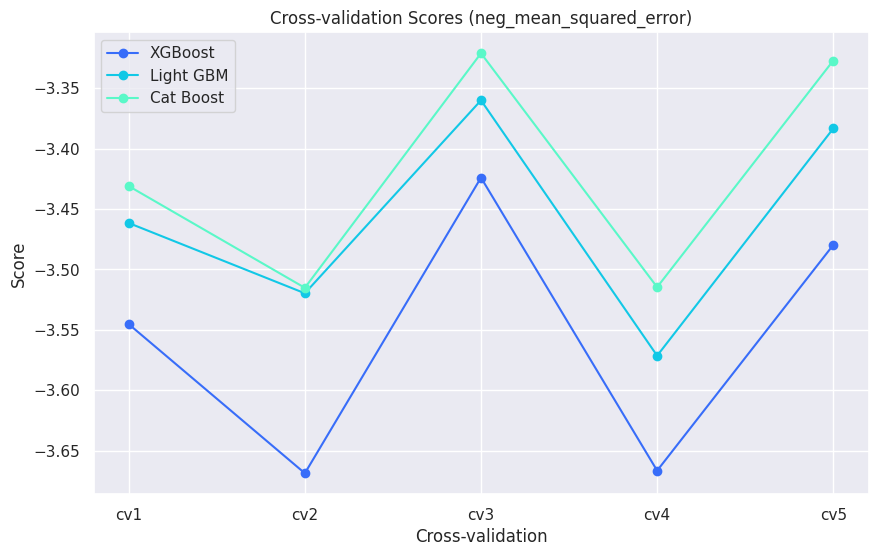

In [83]:
## Plotting the CV score curve;
plot_cv_scores(results, 'neg_mean_squared_error')

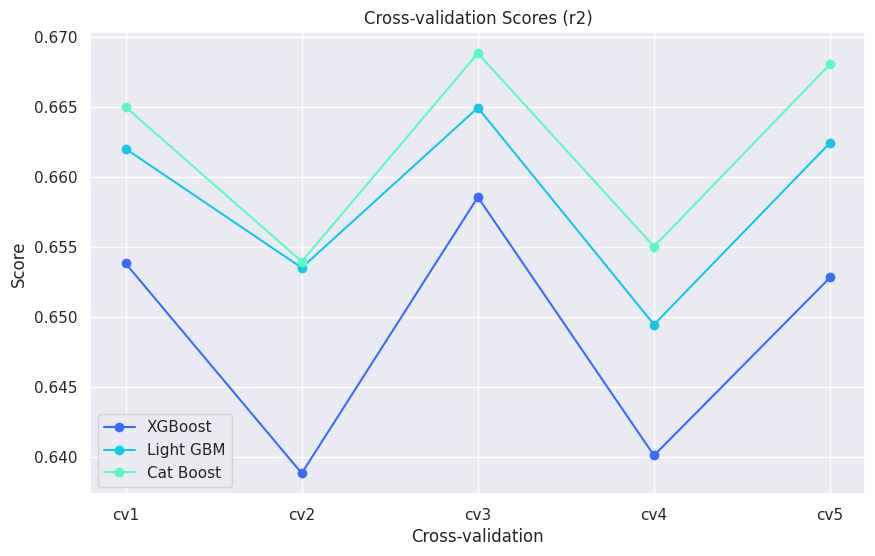

In [84]:
plot_cv_scores(results, 'r2')

In [85]:
final_model=CatBoostRegressor()
final_pipeline=pipeline_flow(final_model)

final_pipeline.fit(X,y)

Learning rate set to 0.081133
0:	learn: 3.0378723	total: 17.9ms	remaining: 17.9s
1:	learn: 2.9112226	total: 32.9ms	remaining: 16.4s
2:	learn: 2.7957805	total: 47.5ms	remaining: 15.8s
3:	learn: 2.6965675	total: 61.6ms	remaining: 15.3s
4:	learn: 2.6043470	total: 75.9ms	remaining: 15.1s
5:	learn: 2.5231082	total: 92.2ms	remaining: 15.3s
6:	learn: 2.4516546	total: 107ms	remaining: 15.2s
7:	learn: 2.3864489	total: 122ms	remaining: 15.2s
8:	learn: 2.3282669	total: 138ms	remaining: 15.2s
9:	learn: 2.2786308	total: 153ms	remaining: 15.2s
10:	learn: 2.2346302	total: 168ms	remaining: 15.1s
11:	learn: 2.1945096	total: 184ms	remaining: 15.2s
12:	learn: 2.1587893	total: 201ms	remaining: 15.2s
13:	learn: 2.1285710	total: 216ms	remaining: 15.2s
14:	learn: 2.1030468	total: 230ms	remaining: 15.1s
15:	learn: 2.0792586	total: 245ms	remaining: 15.1s
16:	learn: 2.0585188	total: 260ms	remaining: 15.1s
17:	learn: 2.0405244	total: 276ms	remaining: 15s
18:	learn: 2.0246544	total: 289ms	remaining: 14.9s
19:	lea

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['Length', 'Diameter',
                                                   'Height', 'Whole weight',
                                                   'Shucked weight',
                                                   'Viscera weight',
                                                   'Shell weight', 'Volume',
                                                   'Viscera Ratio',
                                                   'Shell Ratio',
                                                   'Shell-to-Body Ratio',
                                                   'Meat Yield',
                                                   'Length-to-Diameter Rati...
                                                   'Ratio',
                                                   'Weight-to-ShuckedWeight '
                                                   'Ratio',
                                                   'Surface Area', 'Length^2',
                                                   'Diameter^2', 'Log_Length',
                                                   'Log_Diameter', 'Log_Height',
                                                   'Log_Whole weight',
                                                   'Log_Shucked weight',
                                                   'Log_Viscera weight',
                                                   'Log_Shell weight',
                                                   'Log_Volume']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot_encoder',
                                                                   OneHotEncoder())]),
                                                  ['Sex'])])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7aa816a05cf0>)])

In [86]:
## Checking the validation score;

X_val=df_test.drop(['Rings'],axis=1)
y_val=df_test['Rings']

## Getting predictions from the baseline pipeline;

pred = final_pipeline.predict(X_val)

mean_squared_error(y_val,pred)**0.5

1.8306223864728945

Making the final prediction using CatBoost;

In [87]:
final_model=CatBoostRegressor()

final_pipeline=pipeline_flow(final_model)

## Combining the train and val set;
entire_dataset=pd.concat([df,df_test],axis=0).reset_index(drop=True)
X=entire_dataset.drop(['Rings'],axis=1)
y=entire_dataset['Rings']


## Fitting the data;
final_pipeline.fit(X,y)

## Getting predictions;
final_prediction1 = final_pipeline.predict(test_data.drop(['id'],axis=1))
final_submission1=test_data[['id']]
final_submission1['Rings'] = final_prediction1

final_submission1.to_csv('submission_fe_cboost.csv',index=False)

Learning rate set to 0.084045
0:	learn: 3.0296292	total: 20.6ms	remaining: 20.6s
1:	learn: 2.8986120	total: 38.6ms	remaining: 19.3s
2:	learn: 2.7821329	total: 58.1ms	remaining: 19.3s
3:	learn: 2.6787053	total: 74.6ms	remaining: 18.6s
4:	learn: 2.5848834	total: 91.6ms	remaining: 18.2s
5:	learn: 2.5028901	total: 110ms	remaining: 18.2s
6:	learn: 2.4295397	total: 128ms	remaining: 18.1s
7:	learn: 2.3651910	total: 145ms	remaining: 18s
8:	learn: 2.3076997	total: 163ms	remaining: 18s
9:	learn: 2.2571105	total: 180ms	remaining: 17.8s
10:	learn: 2.2140159	total: 201ms	remaining: 18s
11:	learn: 2.1759170	total: 219ms	remaining: 18.1s
12:	learn: 2.1420998	total: 237ms	remaining: 18s
13:	learn: 2.1122925	total: 255ms	remaining: 17.9s
14:	learn: 2.0872344	total: 272ms	remaining: 17.8s
15:	learn: 2.0642185	total: 290ms	remaining: 17.8s
16:	learn: 2.0443757	total: 307ms	remaining: 17.8s
17:	learn: 2.0270113	total: 325ms	remaining: 17.7s
18:	learn: 2.0116253	total: 341ms	remaining: 17.6s
19:	learn: 1.9

**Hyperparameter tuning the CatBoost model;**

In [88]:
%%time
import optuna

def objective(trial):
    param = {
        'iterations' : trial.suggest_int('iterations', 50, 300),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }
    
    ## Definning the model;
    model = CatBoostRegressor(**param, verbose = 0)
    
    ## Defining the pipeline;
    final_pipeline=pipeline_flow(model)
    
    ## Fitting the model;
    final_pipeline.fit(X, y)
    
    ## Getting the predictions;
    preds = final_pipeline.predict(X_val)
    
    ## Calculating the error;
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-04-27 09:08:04,160] A new study created in memory with name: no-name-49616f3b-dc3c-4e3c-801d-fc23172325a8
[I 2024-04-27 09:08:11,038] Trial 0 finished with value: 2.18700006894269 and parameters: {'iterations': 154, 'depth': 5, 'learning_rate': 0.01019705823003025, 'random_strength': 81, 'bagging_temperature': 1.4527170501794184, 'od_type': 'Iter', 'od_wait': 34}. Best is trial 0 with value: 2.18700006894269.
[I 2024-04-27 09:08:17,801] Trial 1 finished with value: 2.3656774806609344 and parameters: {'iterations': 54, 'depth': 9, 'learning_rate': 0.013977884834923909, 'random_strength': 42, 'bagging_temperature': 73.58162411799671, 'od_type': 'Iter', 'od_wait': 22}. Best is trial 0 with value: 2.18700006894269.
[I 2024-04-27 09:08:39,758] Trial 2 finished with value: 1.8838508334453974 and parameters: {'iterations': 223, 'depth': 10, 'learning_rate': 0.017713461402696952, 'random_strength': 14, 'bagging_temperature': 34.089592981281925, 'od_type': 'IncToDec', 'od_wait': 14}. Be

CPU times: user 41min 59s, sys: 50.6 s, total: 42min 50s
Wall time: 14min 11s


**Displaying the trial, parameters and RMSE at the best performance stage of the model;**

In [89]:
trial = study.best_trial
print(f'trial {trial.number}')
print('rmse: %.2f'% trial.value)
display(trial.params)

params_best = trial.params
display(params_best)

trial 11
rmse: 1.43


{'iterations': 298,
 'depth': 10,
 'learning_rate': 0.2922001711974498,
 'random_strength': 97,
 'bagging_temperature': 5.905461452695865,
 'od_type': 'Iter',
 'od_wait': 43}

{'iterations': 298,
 'depth': 10,
 'learning_rate': 0.2922001711974498,
 'random_strength': 97,
 'bagging_temperature': 5.905461452695865,
 'od_type': 'Iter',
 'od_wait': 43}

In [90]:
## Defining the final - HTuned model;
h_tuned_model =CatBoostRegressor(**params_best)

final_htuned_pipeline=pipeline_flow(h_tuned_model)

cv_scores_mse,cv_scores_r2=model_evaluation(final_htuned_pipeline,X,y)
results=append_to_dataframe(results,'H-Tuned Cat Boost',cv_scores_mse,'neg_mean_squared_error')
results=append_to_dataframe(results,'H-Tuned Cat Boost',cv_scores_r2,'r2')

0:	learn: 2.7126315	total: 78.8ms	remaining: 23.4s
1:	learn: 2.4830787	total: 150ms	remaining: 22.2s
2:	learn: 2.3205606	total: 218ms	remaining: 21.5s
3:	learn: 2.2071889	total: 291ms	remaining: 21.4s
4:	learn: 2.1121450	total: 360ms	remaining: 21.1s
5:	learn: 2.0410195	total: 428ms	remaining: 20.8s
6:	learn: 2.0134561	total: 498ms	remaining: 20.7s
7:	learn: 1.9875235	total: 573ms	remaining: 20.8s
8:	learn: 1.9833996	total: 642ms	remaining: 20.6s
9:	learn: 1.9750806	total: 713ms	remaining: 20.5s
10:	learn: 1.9597660	total: 781ms	remaining: 20.4s
11:	learn: 1.9486160	total: 851ms	remaining: 20.3s
12:	learn: 1.9460604	total: 924ms	remaining: 20.3s
13:	learn: 1.9374644	total: 993ms	remaining: 20.2s
14:	learn: 1.9337620	total: 1.06s	remaining: 20.1s
15:	learn: 1.9263516	total: 1.14s	remaining: 20s
16:	learn: 1.9230863	total: 1.2s	remaining: 19.9s
17:	learn: 1.9182312	total: 1.27s	remaining: 19.8s
18:	learn: 1.9156623	total: 1.34s	remaining: 19.8s
19:	learn: 1.9138706	total: 1.41s	remaining

**Checking for loss improvement due to the effect of H-Tuning along with other baselines;**

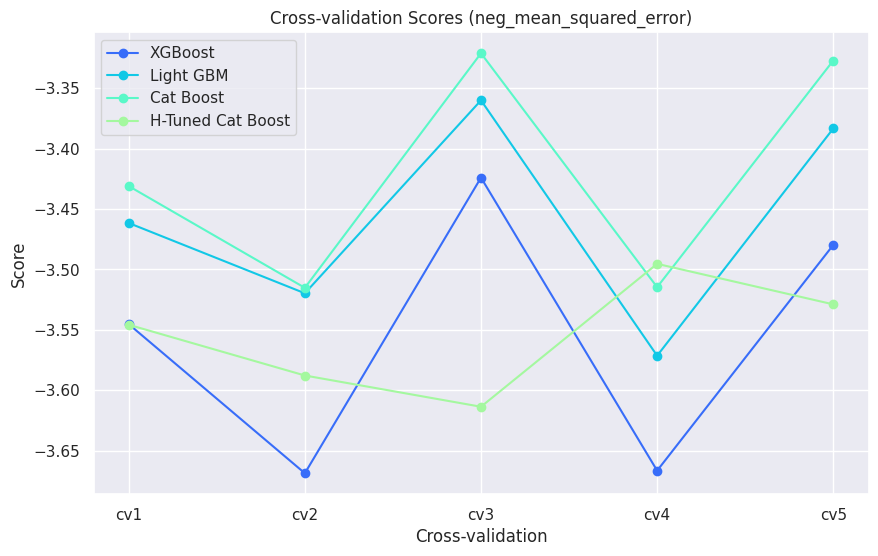

In [91]:
## Plotting the CV score curve;
plot_cv_scores(results, 'neg_mean_squared_error')

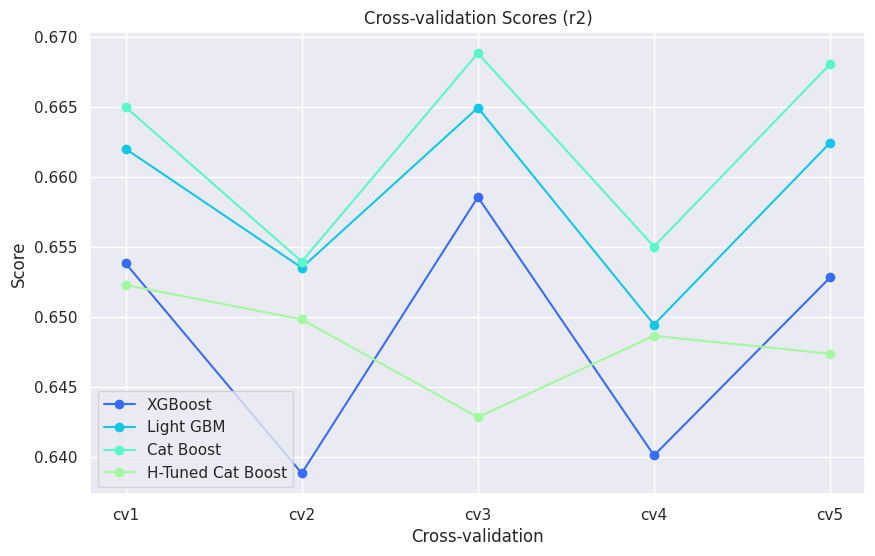

In [92]:
plot_cv_scores(results, 'r2')

Making the submission of the final H-Tuned model;

In [93]:
final_model=CatBoostRegressor(**params_best)

final_pipeline=pipeline_flow(final_model)

## Combining the train and val set;
entire_dataset=pd.concat([df,df_test],axis=0).reset_index(drop=True)
X=entire_dataset.drop(['Rings'],axis=1)
y=entire_dataset['Rings']


## Fitting the data;
final_pipeline.fit(X,y)

## Getting predictions;
final_prediction1 = final_pipeline.predict(test_data.drop(['id'],axis=1))
final_submission1=test_data[['id']]
final_submission1['Rings'] = final_prediction1

final_submission1.to_csv('submission_fe_htuned_cboost.csv',index=False)

0:	learn: 2.7145091	total: 77.3ms	remaining: 23s
1:	learn: 2.4997695	total: 154ms	remaining: 22.7s
2:	learn: 2.3251156	total: 228ms	remaining: 22.4s
3:	learn: 2.2117839	total: 305ms	remaining: 22.4s
4:	learn: 2.1132161	total: 380ms	remaining: 22.3s
5:	learn: 2.0411389	total: 456ms	remaining: 22.2s
6:	learn: 2.0114007	total: 534ms	remaining: 22.2s
7:	learn: 1.9908724	total: 610ms	remaining: 22.1s
8:	learn: 1.9858928	total: 685ms	remaining: 22s
9:	learn: 1.9772332	total: 766ms	remaining: 22s
10:	learn: 1.9606845	total: 841ms	remaining: 21.9s
11:	learn: 1.9486074	total: 918ms	remaining: 21.9s
12:	learn: 1.9463511	total: 999ms	remaining: 21.9s
13:	learn: 1.9402918	total: 1.07s	remaining: 21.8s
14:	learn: 1.9374118	total: 1.15s	remaining: 21.7s
15:	learn: 1.9292041	total: 1.23s	remaining: 21.6s
16:	learn: 1.9264906	total: 1.3s	remaining: 21.5s
17:	learn: 1.9212852	total: 1.38s	remaining: 21.4s
18:	learn: 1.9184335	total: 1.46s	remaining: 21.4s
19:	learn: 1.9168842	total: 1.53s	remaining: 21

**Final Notes;**

Hope the readers found this notebook useful. Please **upvote** if you did so! Also please comment on things that I can try upon. Always open to ideas!

Thank You!!